## This book focuses on creating a language analysis for countries
This takes a csv file of different speech texts made by different countries in the UN OEWG meeting, analyses the texts by words often used by speakers 

In [35]:
#import needed libraries
import pandas as pd
import numpy  as np
import spacy
from spacy.util import compile_infix_regex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics  import silhouette_samples, silhouette_score
from wordcloud  import WordCloud


In [2]:
df = pd.read_csv('csv/Meeting_5_Session_3.csv')
df.head()

,Id,Session,Meeting,Speaker,Text
0,S3M51,3,5,Chairman,"Good morning, distinguished delegates. Please ..."
1,S3M52,3,5,Russia,Mr. Chairman. We would like to take the floor ...
2,S3M53,3,5,Chairman,I thank the distinguished representative of th...
3,S3M54,3,5,New Zealand,"Thank you, Mr. Chair, when New Zealand conside..."
4,S3M55,3,5,Chairman,I thank the distinguished representative of Ne...


In [3]:
#remove all rows with "Chairman" in the speaker column and store in a new df
df_updated = df[df['Speaker'] != 'Chairman']
#get the number of rows
print(f' number of rows is {df_updated.shape[0]}')


 number of rows is 37


In [4]:
#save all text column in a list
corpus = df_updated['Text'].tolist()
corpus[0][:100]

'Mr. Chairman. We would like to take the floor on both sub items on the topic. Two subtopic A&B, In c'

In [5]:
#where there '-' is an independent word, merge the word before and after it
edited_corpus = []

for document in corpus:
    words = document.split()
    merged_words = []
    i = 0
    while i < len(words):
        if words[i] == "-" and i > 0 and i < len(words) - 1:
            merged_words[-1] = merged_words[-1] + words[i + 1]
            i += 2  # Skip the next word
        else:
            merged_words.append(words[i])
            i += 1
    edited_corpus.append(' '.join(merged_words))


In [6]:
#check if '-' is a standalone word and print the word before it
for document in edited_corpus:
    words = document.split()
    for i, word in enumerate(words):
        if word == "-" and i > 0:  # Check if "-" is not the first word
            print("Word before standalone '-':", words[i - 1])

In [7]:
def merge_words_after_anti(corpus):
    merged_corpus = []
    for text in corpus:
        words = text.split()
        merged_words = []
        i = 0
        while i < len(words):
            if words[i] == 'anti' and i < len(words) - 1:
                merged_words.append( words[i] + words[i + 1])
                i += 2
            else:
                merged_words.append(words[i])
                i += 1
        merged_text = ' '.join(merged_words)
        merged_corpus.append(merged_text)
    return merged_corpus

merge_anti_corpus = merge_words_after_anti(edited_corpus)

In [8]:
#check if 'anti' is a standalone word and print the word after it
for text in merge_anti_corpus:
    words = text.split()
    for i in range(len(words) - 1):
        if words[i] == 'anti':
            print('anti', words[i + 1])

In [9]:
#print all unique words that contain 'anti'
unique_words_with_anti = set()

for text in merge_anti_corpus:
    words = text.split()
    for word in words:
        if 'anti' in word:
            unique_words_with_anti.add(word)

for word in unique_words_with_anti:
    print(word)

substantive
anti-missile
anti-space
antimissile
substantiated
unsubstantiated
antispace
anticipated
anti-satellite


In [10]:
def filter_text(text):
    #convert text to lowercase
    text = text.lower()
    # Load the language model
    nlp = spacy.load("en_core_web_sm")

    # Get default infix patterns
    infixes = nlp.Defaults.infixes

    # Create a new list of infixes excluding any infixes containing 'anti' or '-'
    infixes = [infix for infix in infixes if 'anti' not in infix and '-' not in infix]

    # Update the infix patterns
    nlp.tokenizer.infix_finditer = compile_infix_regex(infixes).finditer
    stop_words_list = []

    # Process the text  
    doc = nlp(text)

    # Get the stop words
    stop_words = nlp.Defaults.stop_words
    # store the stop words
    for word in stop_words:
        stop_words_list.append(word)

    # Add custom stop words
    custom_stop_words = ['in', 'to', 'of', 'the', 'and', 'on', 'with', 'as', 'for', 'or', 'we','mr.', 'mr','chairman','chair', 'chairperson','thank']
    for word in custom_stop_words:
        stop_words_list.append(word)

    # Filter out stop words and lemmatize the tokens
    filtered_tokens = [token.lemma_ for token in doc if token.text not in stop_words_list]
    # Join the tokens back into a single string
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [11]:
merge_anti_corpus

['Mr. Chairman. We would like to take the floor on both sub items on the topic. Two subtopic A&B, In conjunction in this connection. We would like to underscore. That outer space capabilities, also called antispace capabilities are one of the key categories of systems. Which require very serious consideration and regulation as part of the work to prevent an arms race in outer space. It is our view that discussion of norms, rules, and principles, Concerning such systems. Require consideration of the aspects of the functioning of those systems that are both Earth and space based. As we have already noted in light of the growing threat of weaponization of space in connection with the policy of a series of UN member states To place weapons in space And use outer space for undertaking military activity With a view to ensuring their dominance And prevalence superiority. There is a need as an intermediary measure to affirm the predominance Of the existing and enforce international legal norms

In [12]:
#filter the text in the corpus
filter_corpus = [filter_text(text) for text in merge_anti_corpus]
filter_corpus

['. . like floor sub item topic . subtopic a&b , conjunction connection . like underscore . outer space capability , call antispace capability key category system . require consideration regulation work prevent arm race outer space . view discussion norm , rule , principle , concern system . require consideration aspect functioning system earth space base . note light grow threat weaponization space connection policy series un member state place weapon space use outer space undertake military activity view ensure dominance prevalence superiority . need intermediary measure affirm predominance exist enforce international legal norm principle regulate activity space . foremost , 1967 space treaty resolution un general assembly special session disarmament 1978 ssot 1as series document reference yesterday morning . time permanent importance backdrop address concern , remove concern regard potential system capability prohibition placement weapon space prohibition use force threat force . co

In [17]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(filter_corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(20, 0)

37 rows


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
space,0.319774,0.299303,0.297778,0.277973,0.059697,0.0,0.387748,0.394780,0.000000,0.294394,...,0.353961,0.144303,0.127665,0.347774,0.067981,0.147592,0.044230,0.084180,0.029505,0.309958
connection,0.217453,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108764,0.000000,0.000000
system,0.175655,0.068655,0.000000,0.000000,0.000000,0.0,0.032118,0.076775,0.035194,0.109734,...,0.087958,0.035859,0.301382,0.060294,0.000000,0.036676,0.000000,0.000000,0.131976,0.000000
state,0.159814,0.121456,0.048335,0.000000,0.000000,0.0,0.022728,0.108658,0.099618,0.110931,...,0.217849,0.101500,0.044899,0.119465,0.035862,0.051907,0.139997,0.044408,0.031130,0.072673
weapon,0.148837,0.122163,0.000000,0.070235,0.000000,0.0,0.000000,0.030358,0.000000,0.148769,...,0.000000,0.000000,0.112899,0.057219,0.020040,0.130522,0.000000,0.000000,0.052185,0.030457
anti,0.146961,0.150779,0.100007,0.086688,0.000000,0.0,0.047025,0.000000,0.000000,0.160665,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
group,0.143515,0.000000,0.000000,0.033862,0.101810,0.0,0.000000,0.000000,0.040256,0.000000,...,0.000000,0.000000,0.036288,0.055173,0.000000,0.000000,0.075431,0.000000,0.050320,0.014684
task,0.140086,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.029517,0.044879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
earth,0.134142,0.091751,0.045642,0.118689,0.000000,0.0,0.000000,0.068403,0.047034,0.000000,...,0.000000,0.000000,0.000000,0.048347,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
obligation,0.130472,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.027491,0.062698,0.000000,0.000000,0.000000,0.000000,0.000000,0.022249


In [23]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [21]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [24]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instea

In [30]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

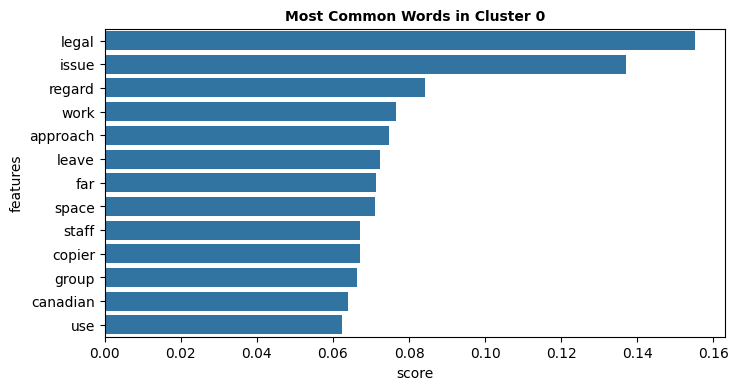

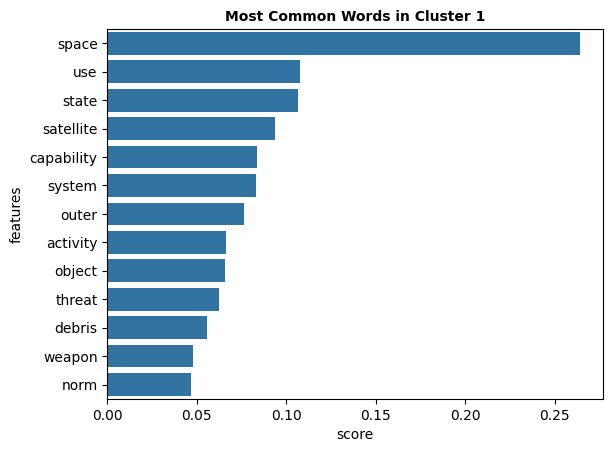

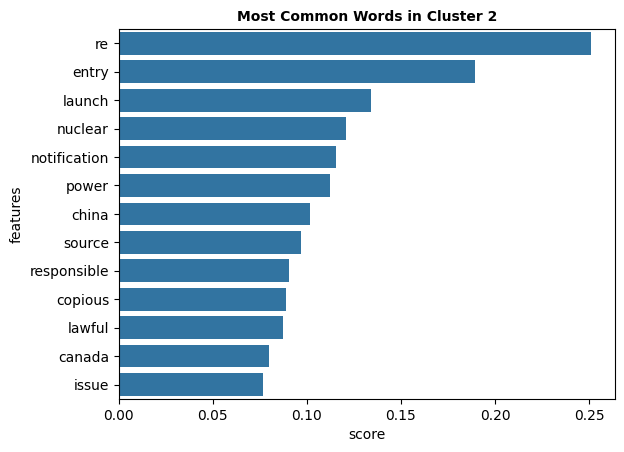

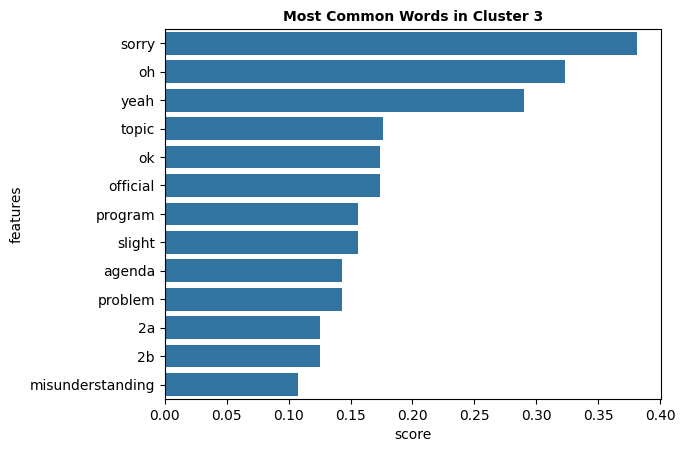

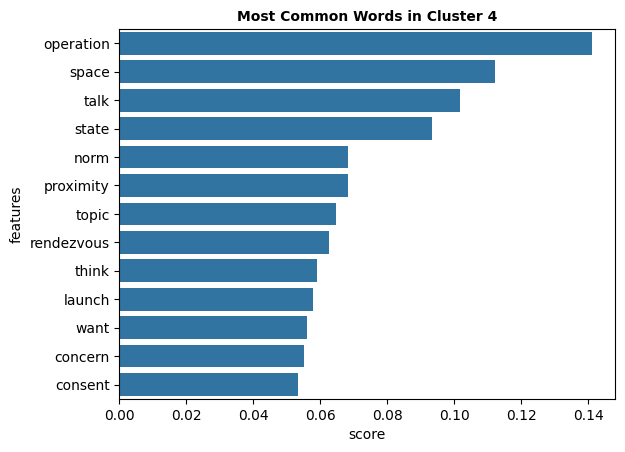

In [31]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [36]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

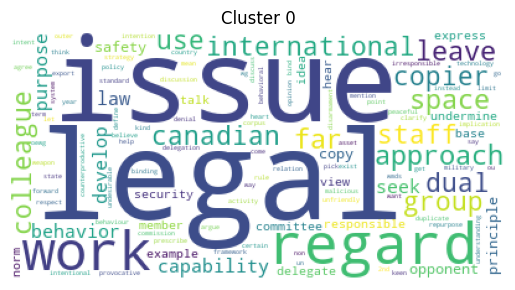

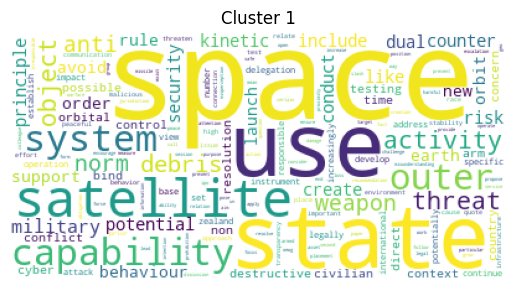

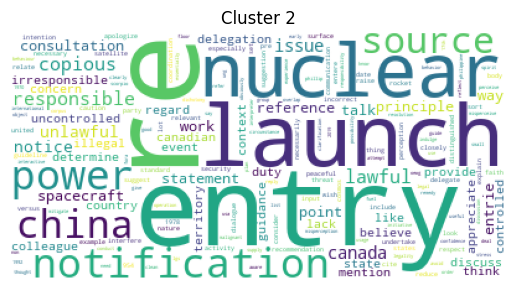

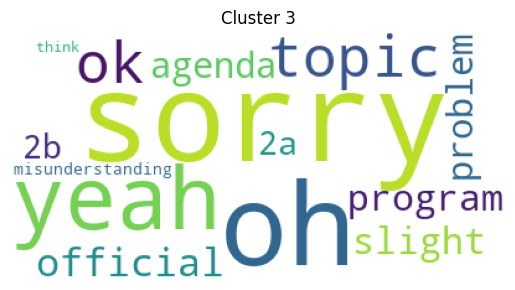

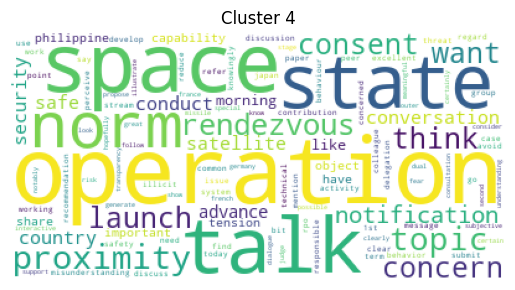

In [37]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [48]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
df_updated['Cluster'] = labels
df_updated.head()

/var/folders/5r/2zxjpss509zbfp38213y6wv00000gn/T/ipykernel_84515/1057708629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_updated['Cluster'] = labels


,Id,Session,Meeting,Speaker,Text,Cluster
1,S3M52,3,5,Russia,Mr. Chairman. We would like to take the floor ...,1
3,S3M54,3,5,New Zealand,"Thank you, Mr. Chair, when New Zealand conside...",1
5,S3M56,3,5,Italy,"Thank you, Mr. Chair. As we said many times be...",1
7,S3M58,3,5,China,"Thank you, Mr. Chairman. China believes that d...",1
9,S3M510,3,5,Canada,"Thank you, Mr. Chair. Hopefully we can get a l...",4


In [47]:
#drop the label column
#

/var/folders/5r/2zxjpss509zbfp38213y6wv00000gn/T/ipykernel_84515/794651026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_updated.drop(columns = ['label'], inplace = True)


,Id,Session,Meeting,Speaker,Text,Cluster
1,S3M52,3,5,Russia,Mr. Chairman. We would like to take the floor ...,1
3,S3M54,3,5,New Zealand,"Thank you, Mr. Chair, when New Zealand conside...",1
5,S3M56,3,5,Italy,"Thank you, Mr. Chair. As we said many times be...",1
7,S3M58,3,5,China,"Thank you, Mr. Chairman. China believes that d...",1
9,S3M510,3,5,Canada,"Thank you, Mr. Chair. Hopefully we can get a l...",4


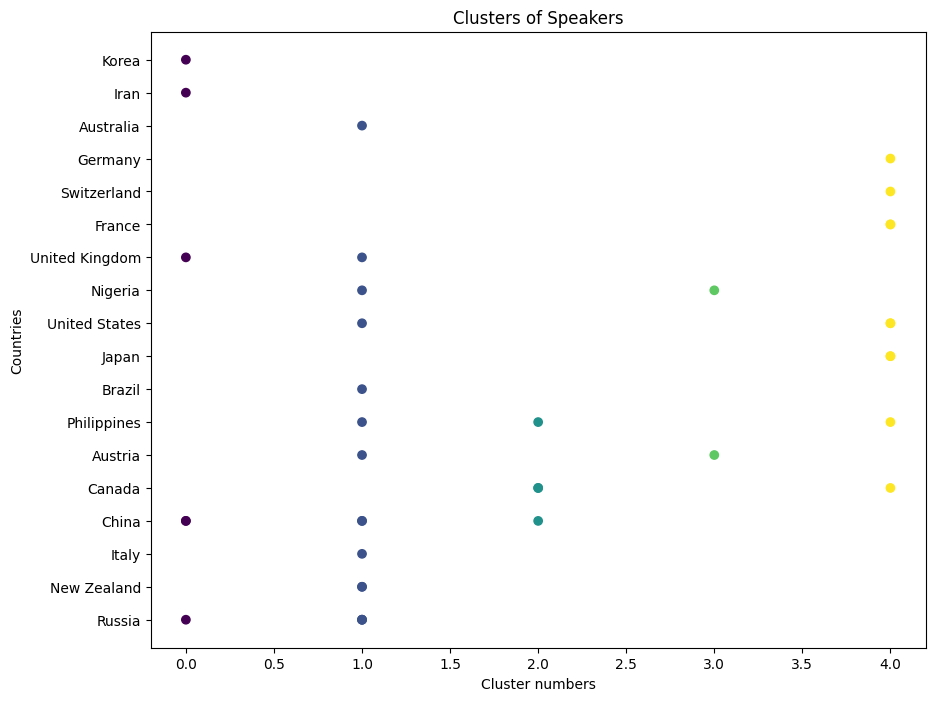

In [50]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(df_updated['Cluster'], df_updated['Speaker'], c=df_updated['Cluster'], cmap='viridis')

# Add labels and title
plt.xlabel('Cluster numbers')
plt.ylabel('Countries')
plt.title('Clusters of Speakers')

# Show the plot
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


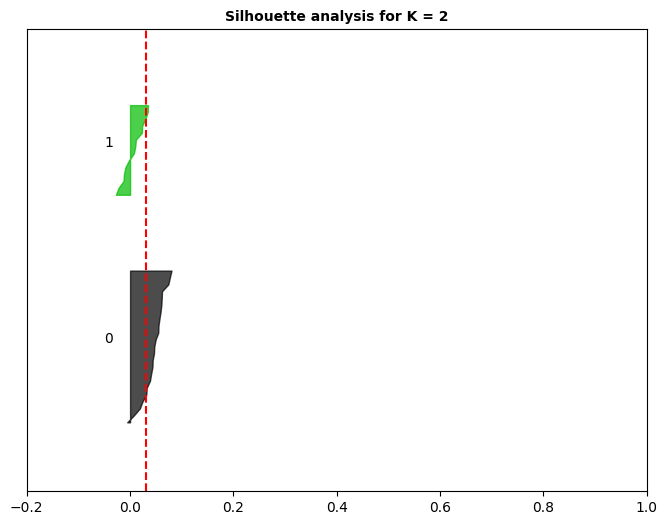

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


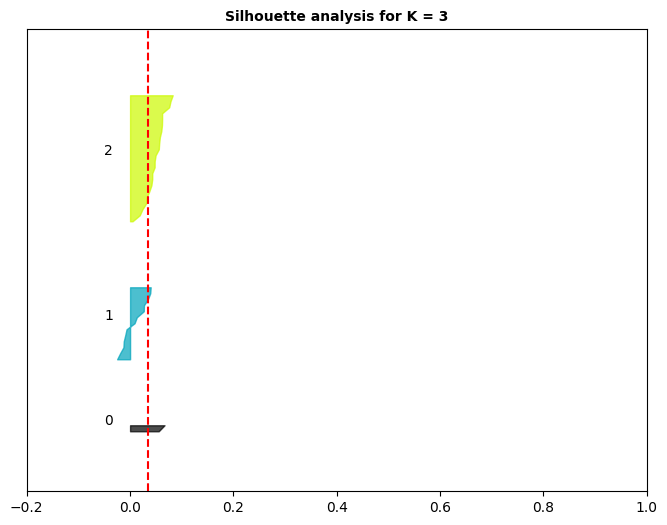

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


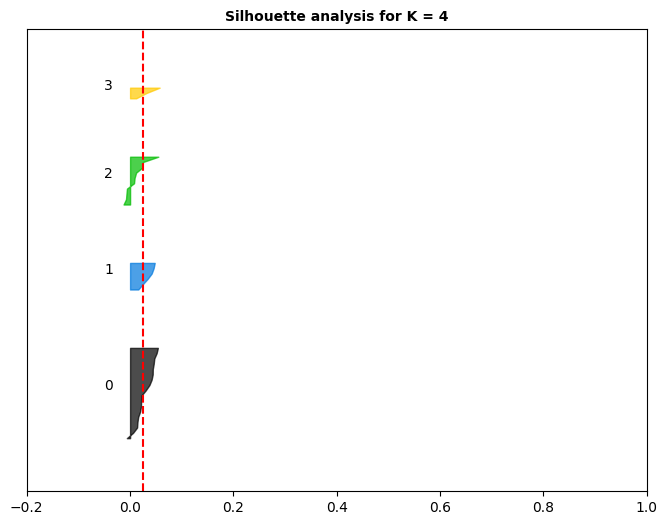

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


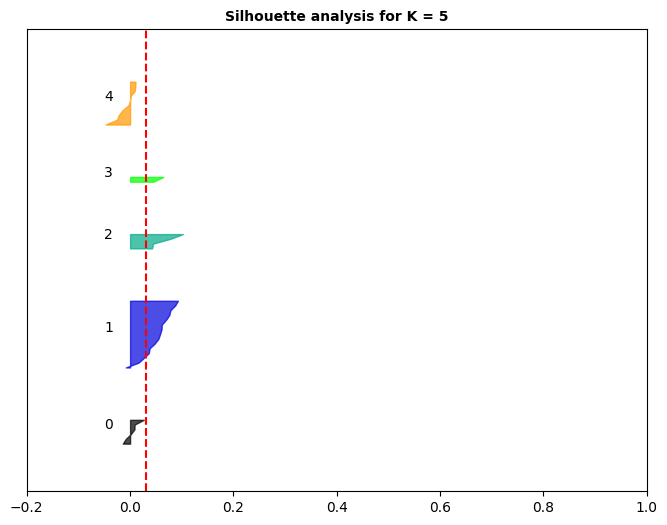

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


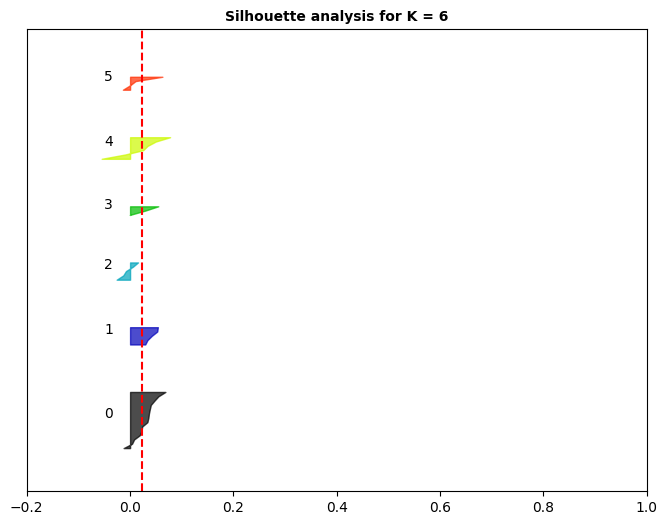

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


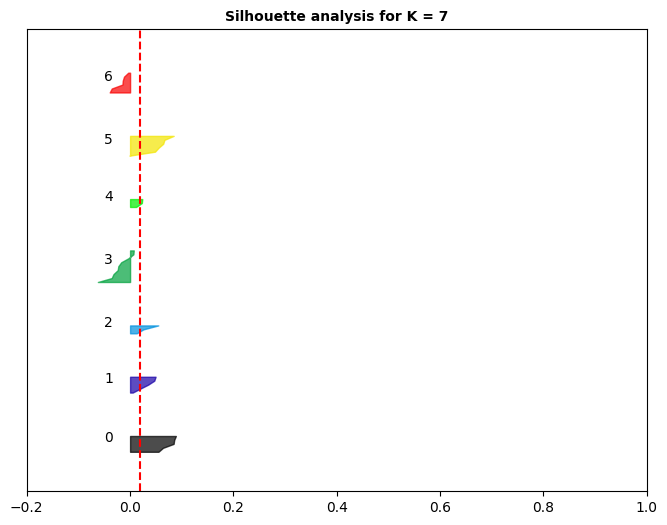

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


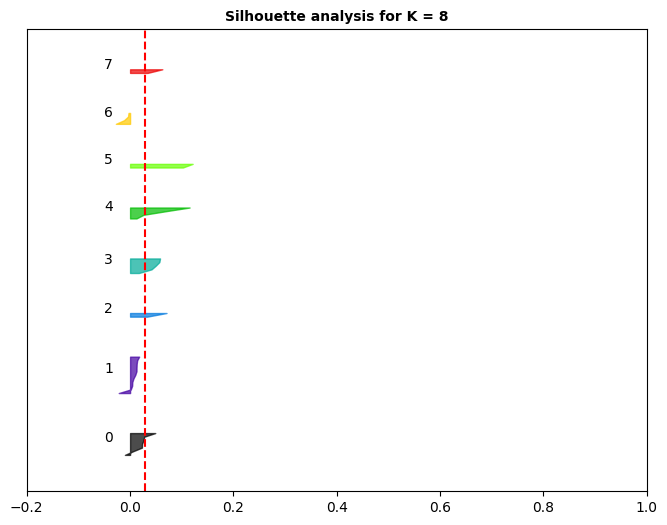

In [51]:
# Plotting Silhouette Analysis - For Evaluation
silhouette(kmeans_results, final_df, plot=True)

In [52]:
#save the df_updated into a csv file in the csv folder
df_updated.to_csv('Language_analysis/Meeting_5_Session_3_language_analysis.csv', index=False)
